# Chapter 21

# How certain is the model; parametric bootstrapping
Bill Henderson
## Introduction  

Previously, we have investigated the nonparametric bootstrap resampling method. We used bootstrap resampling to compute a point estimate and confidence interval for simple univariate statistics.

The bootstrap method can also be applied to regression models. Computing the bootstrap distribution of the regression model parameters provides insight into variability of these parameters. It is useful to know how much random variation there is in regression coefficients simply because of a small change in training data values.   

To proceed, we need to define our terminology:  

- **Parametric bootstrap:** Linear regression is an example of a **parametric model**. Simply, a parametric model is a model with parameters which must be estimated. A parametric bootstrap process is used to find point estimates of the model parameters and the associated uncertainty or confidence intervals. For each bootstrap resample created, a new estimate of the model parameters is computed. For example, a regression model estimates parameters that minimize the sum of squared errors. In the previous chapter, we showed that this least squares model assumes a Normal likelihood model for the residuals, making application of a bootstrap algorithm parametric.      
- **Nonparametric bootstrap:** Some statistical estimates have no particular model associated with them. Examples include the mean, variance and bootstrap confidence intervals. These values can be estimated using the bootstrap method without specifying a parametric model. The nonparametric bootstrap makes no assumptions about a likelihood model, and therefore has no parameters.  

Which bootstrap model should you use? The answer is not straight forward. You must consider the following:
1. Generally, the parametric bootstrap gives tighter confidence intervals, if the model assumptions are reasonably correct. 
2. If the model assumptions are violated, the parametric bootstrap will give poor results and a nonparametric bootstrap is preferred. 

As with most statistics, it is possible to bootstrap the parameters of most any regression model. However, since bootstrap resampling uses a large number of subsamples, it can be computationally intensive. For large-scale problems it is necessary to use other resampling methods like cross-validation.

## An Example

Let's try an example. We will work with a simple regression model similar to the one used in Chapter 19. 

As a first step, execute the code in the cell below to import the required packages and generate a synthetic data set. 

In [10]:
import numpy as np
import numpy.random as nr
import pandas as pd
import statsmodels.formula.api as sm
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Paramters of generated data
n_points = 50
x_start, x_end = 0, 10
y_sd = 1

# Generate data columns
nr.seed(5666)
x_data = np.linspace(x_start, x_end, n_points) # The x values
y_error = np.random.normal(loc=0, scale=y_sd, size=n_points) # The Normally distributed noise
y_data = x_data + y_error + 1.0 # The y values including an intercept

# Put data in dataframe
sim_data = pd.DataFrame({'x':x_data, 'y':y_data})

sim_data.head()

,x,y
0,0.000000,1.475868
1,0.204082,0.915564
2,0.408163,2.216802
3,0.612245,1.362557
4,0.816327,3.521151


Now, plot these data and examine the result by executing the code in the cell below.  

(0.0, 11.0)

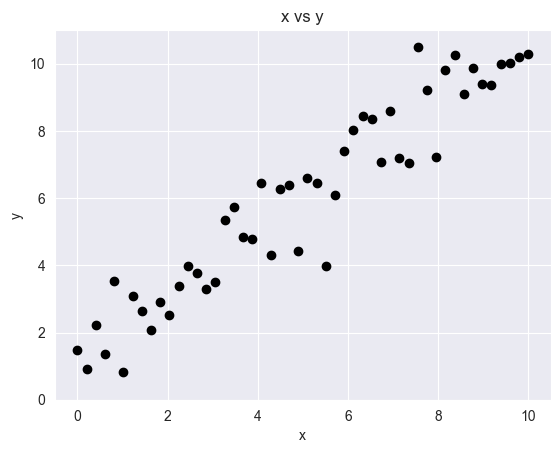

In [11]:
# Matplotlib may give some font errors when loading for the first time, you can ignore these
plt.plot(sim_data['x'], sim_data['y'], 'ko')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')
plt.ylim(0,11)

## Parametric Bootstrap of Regression

We will now apply the parametric bootstrap algorithm to a simple parametric model, a regression model. The work is done in a `for loop`, run once for each bootstrap sample with the following steps:   
1. Bernoulli sample the rows of the data frame with replacement with same number of rows as the original frame.    
2. Compute the OLS model using the Bernoulli sample.   
3. Save the model parameters in the data frame to be returned.   
Execute the code below and example the result.   

In [12]:
def resample_regression(df, n_boots, n_params=2, formula='y ~ x'):
    ## array to hold the bootstrap samples of the parameters
    boot_samples = np.zeros((n_boots,n_params))
    n_samples = df.shape[0]
    ## Loop over the number of resamples
    for i in range(n_boots):
        ## Create a bootstrap sample of the data frame
        boot_sample = df.sample(n=n_samples, replace=True)
        ## Compute the OLS model
        boot_model = sm.ols(formula=formula, data=boot_sample).fit()
        ## Save the model parameters in the array
        boot_samples[i,:] = boot_model._results.params
    return boot_samples

param_boots = resample_regression(sim_data,2000)
param_boots[:5]

array([[1.13290799, 0.98560489],
       [1.34751537, 0.93057827],
       [1.36160617, 0.94383043],
       [1.1759036 , 0.99644286],
       [1.16683758, 0.99379272]])

You can see the first few bootstrap estimates of the intercept and slope coefficients. Notice the resampling leads to considerable variation in these values.       

Let's compute and display the bootstrap distributions of the slope and intercept parameters. Execute the code in the cell below to examine the distribution of the intercept, along with the confidence intervals. 

Mean = 1.300852333455449
Upper confidence interval = 1.715510719752699
Lower confidence interval = 0.8977496367224282


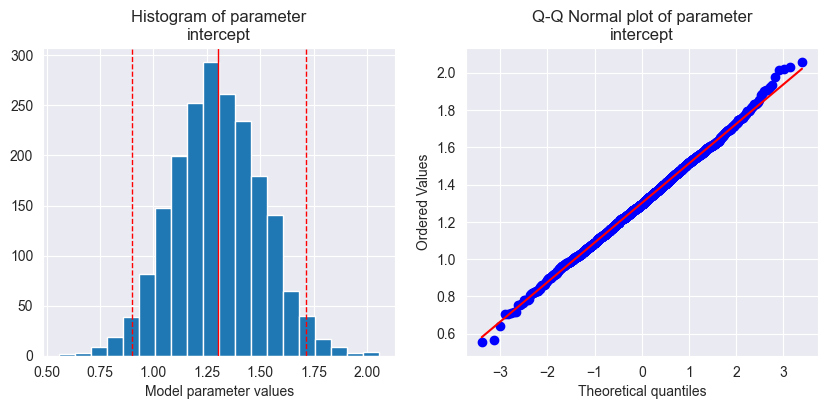

In [13]:
def compute_CI(values, p=0.05):   
    mean = np.mean(values)
    p = 100 * p / 2.0
    UCI = np.percentile(values, 100 - p)
    LCI = np.percentile(values, p)
    print(f'Mean = {mean}')
    print(f'Upper confidence interval = {UCI}')
    print(f'Lower confidence interval = {LCI}')
    return(mean, UCI, LCI)

def plot_boot_params(params, parameter='intercept'):
    mean, UCI, LCI = compute_CI(params)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    ax[0].hist(params, bins=20)
    ax[0].axvline(mean, color='red', linewidth=1)
    ax[0].axvline(UCI, color='red', linewidth=1, linestyle='--')
    ax[0].axvline(LCI, color='red', linewidth=1, linestyle='--')
     
    ax[0].set_title('Histogram of parameter\n' + parameter)
    ax[0].set_xlabel('Model parameter values')
    ## Plot the Q-Q Normal plot
    ss.probplot(params, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of parameter\n' + parameter)
    plt.show()

plot_boot_params(param_boots[:,0])

Next, execute the code in the cell below to display a plot of the slope parameter, along with the confidence intervals. 

Mean = 0.9419628015641599
Upper confidence interval = 1.0149980300933885
Lower confidence interval = 0.8736302602148219


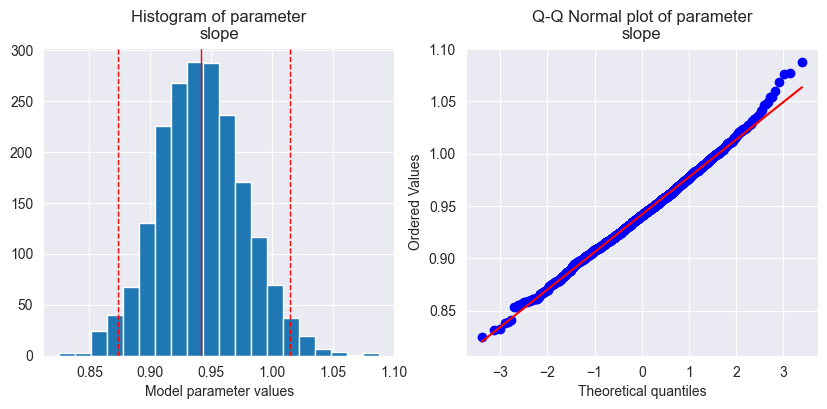

In [14]:
plot_boot_params(param_boots[:,1], parameter='slope')

From the plots above you can see the variability and confidence intervals of the parameter estimates. Consider the answers to the following questions:  
1. Are the bootstrap distribution values approximately Normal?
2. Does one coefficient have greater variability than the other, and if so, which one?  
3. Are the known parameter values of the synthetic data within the confidence intervals? 

You can also plot bootstrap realizations of the regression line. This will give you a feel for the variability of the regression solutions. Execute the code in the cell below and examine the result.    

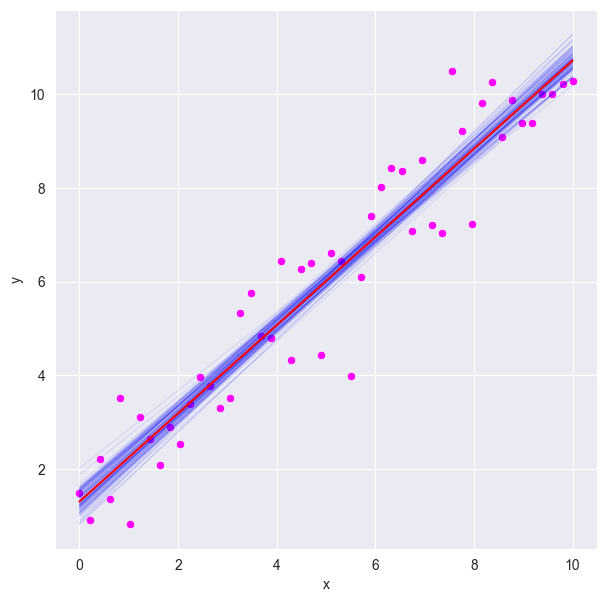

In [15]:
def plot_boot_regression(boot_params, df, plot_x_col='x', plot_y_col='y', cols='x', xlabel='x', ylabel='y', n_lines = 100):  
    ## Find the mean slope and intercept and plot the line 
    means = np.mean(boot_params, axis=0)
    ## randomly select n_lines to plot
    sample_indx = nr.choice(range(boot_params.shape[0]),n_lines)
    ## Plot the observations
    fig,ax = plt.subplots(figsize=(7,7))
    ax = sns.scatterplot(x=plot_x_col, y=plot_y_col, data=df, color = 'magenta', ax=ax)
    ## Loop over the number of bootstrap regression lines to be displayed
    for indx in sample_indx:     
        df['predicted'] = boot_params[indx,0] + np.multiply(df[cols], boot_params[indx,1:])
        sns.lineplot(x=plot_x_col, y='predicted', data=df, color='Blue', size = 1.0, alpha=0.1, ax=ax)
    ## Plot the mean regression line
    df['predicted'] = means[0] + np.multiply(df[cols] ,means[1:])
    sns.lineplot(x=plot_x_col, y='predicted', data=df, color='red', ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.get_legend().remove()
    
plot_boot_regression(param_boots, sim_data)    

The plot above shows the following:   
1. The heavy line is the mean parameter regression line.   
2. The light blue lines show a selected number of the bootstrap regression lines. Notice the variability in these possible models. 

## Another Example      

To further illustrate the foregoing concepts you will now work though another example using the auto price data.  

> **Exercise 21-1:** As a first step you will construct a parametric OLS regression model for the price of automobiles. The code in the cell below loads and prepares the auto price dataset. To compute and display the bootstrap distributions of the model parameters do the following:    
> 1. Use the `resample_regression` function to compute 2000 bootstrap realizations of a regression model using formula `'log_price ~ curb_weight_centered*engine_size_centered'`. This model includes the interaction term between the two independent variables.   
> 2. For each set of model parameters call the `plot_boot_params`. The first argument is the column of your bootstrap parameter Numpy array. The second, `parameter`, argument set to the parameter name in `['intercept', 'curb_weight_centered','engine_size_centered', 'curb_weight_centered:engine_size_centered']`.      

Mean = 9.399842671650685
Upper confidence interval = 9.447871753644835
Lower confidence interval = 9.352361172209513


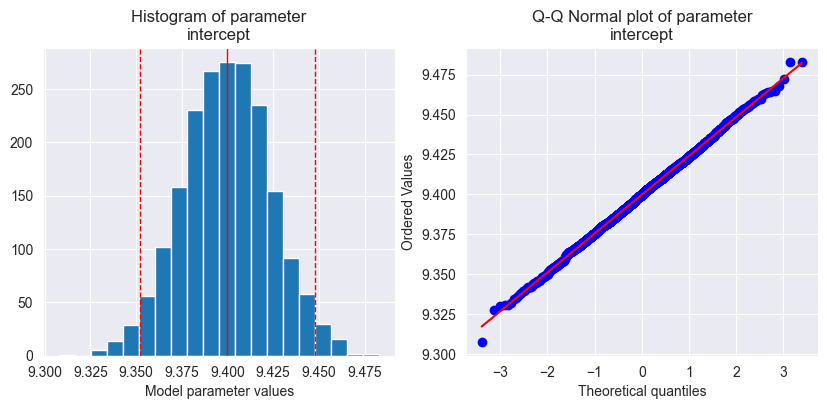

Mean = 0.0004921560124281443
Upper confidence interval = 0.0006616634597558245
Lower confidence interval = 0.0003433181842695878


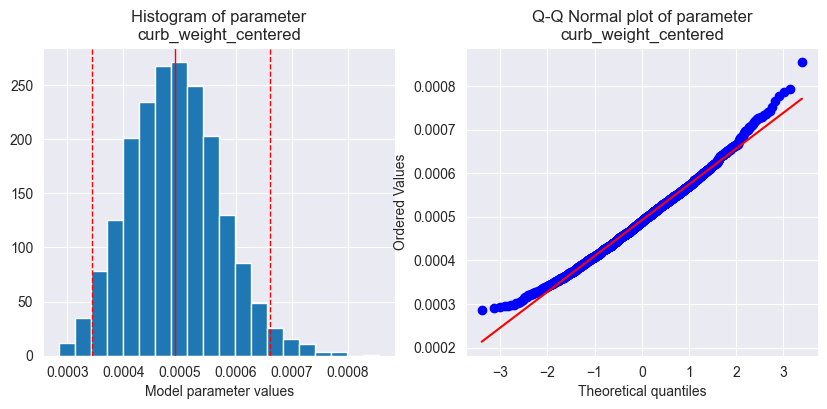

Mean = 0.006929429706564381
Upper confidence interval = 0.009678846583433522
Lower confidence interval = 0.0038097790044566227


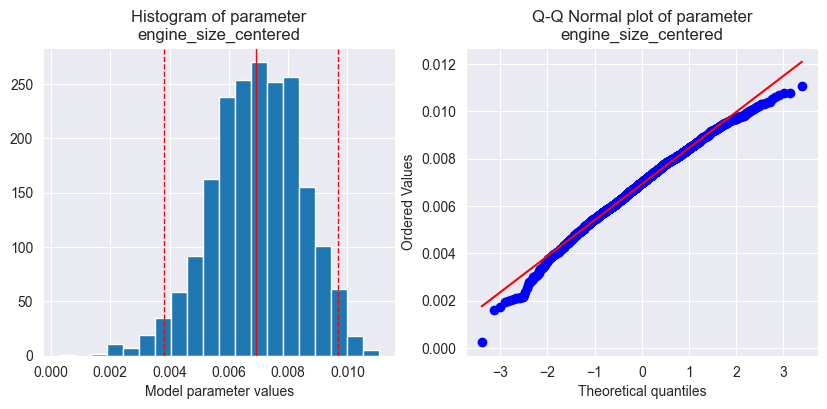

Mean = -2.711309201709064e-06
Upper confidence interval = -1.0326794412982872e-06
Lower confidence interval = -4.164920902383932e-06


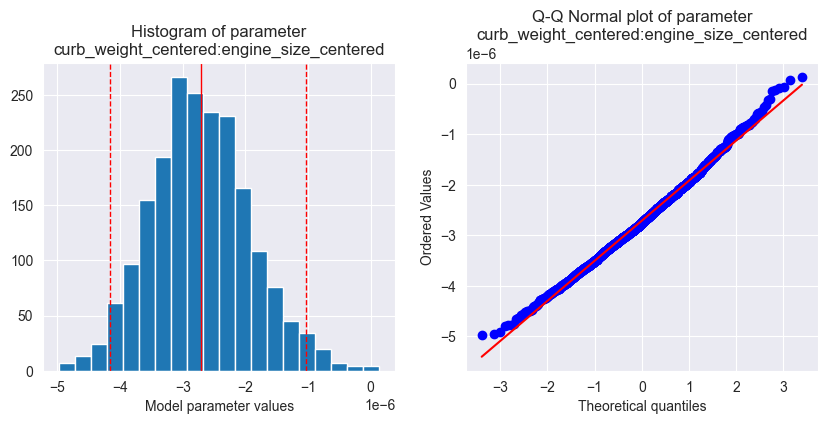

In [24]:
## Prepare the dataset
auto_price = pd.read_csv('../data//AutoPricesClean.csv')
auto_price['log_price'] = np.log(auto_price.loc[:,'price'])
for col,new_col in zip(['curb_weight','engine_size'],['curb_weight_centered','engine_size_centered']):
    auto_price[new_col] = auto_price.loc[:,col] - np.mean(auto_price.loc[:,col])

np.random.seed(2244)    
## Put your code below
auto_boots = resample_regression(auto_price, 2000, n_params=4, formula='log_price ~ curb_weight_centered * engine_size_centered')

_ = [ plot_boot_params(auto_boots[:,i], parameter=x) for i,x in enumerate(['intercept', 'curb_weight_centered','engine_size_centered', 'curb_weight_centered:engine_size_centered'])]

> Now answer the following questions:     
> 1. Are the bootstrap distributions of all the variables Normally distributed or is the noticeable skew?  If skew is present, describe the skew for each parameter.    
> 2. Examine the 95% confidence intervals for each of the model parameters. Based on these CIs are all the parameters significant and if not, which parameters are not significant and why?     

> **Answers:**    
> 1. There is skew in all the variables. The intercept has some right skew, curb_weight_centered is left skewed, engine_size_centered is a right skewed, and the curb_weight_centered:engine_size_centered is slightly left skewed.           
> 2. curb_weight_centered and engine_size_centered are close to being insignificant but are barely significant since they're very close to crossing the zero threshold, and with enough rounding, could do so. Depending on precision, they could be ruled insignificant, the other two are fine.            

> **Exercise 21-2:** In the foregoing exercise, you have identified which regression model parameters are significant. Now, repeat the analysis you performed in Exercise 21-1, but using a model formula including only the significant parameters.  

Mean = 9.242545176037423
Upper confidence interval = 9.309165290182133
Lower confidence interval = 9.178286655265786


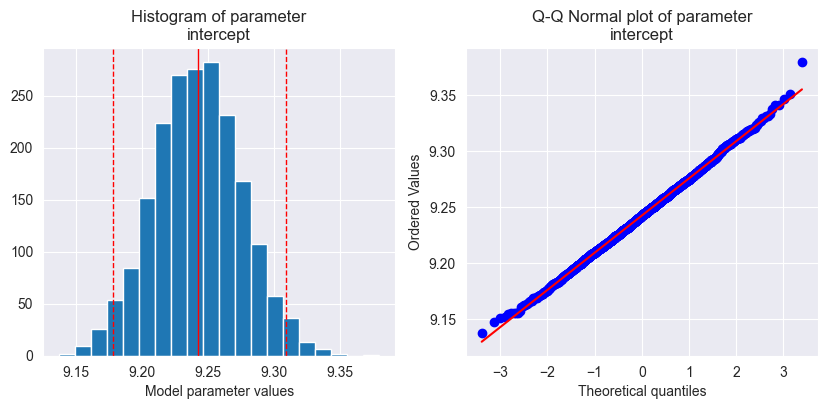

Mean = 5.751130771939875e-06
Upper confidence interval = 7.35997351651142e-06
Lower confidence interval = 4.161992939772398e-06


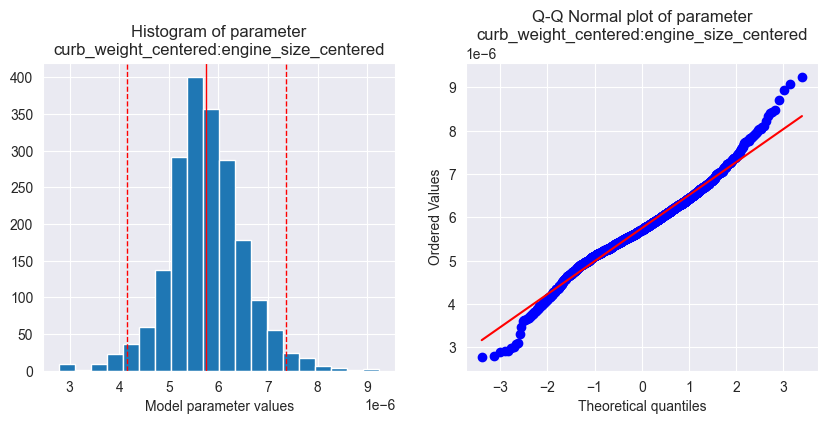

In [25]:
## Put your code below
auto_boots_sig = resample_regression(auto_price, 2000, n_params=2, formula='log_price ~ curb_weight_centered : engine_size_centered')

_ = [ plot_boot_params(auto_boots_sig[:,i], parameter=x) for i,x in enumerate(['intercept', 'curb_weight_centered:engine_size_centered'])]




> Answer the following questions:    
> 1. Are all the parameters of your model significant now and why?    
> 2. Are the bootstrap distributions of the parameters reasonably Normal and why?    

> **Answers:**    
> 1. Yes, all parameters are now  significant because neither are anywhere near crossing the zero threshold.            
> 2. Yes, the bootstrap distributions of the parameters are pretty well normally distributed with little skew and only a couple non-normal values in the tails. This is most likely due to the sampling of the bootstrapping picking ideal values for an outlying parameter estimate, which we can see from the chart is very unlikely, only happening outside the second quartiles in either direction.             

#### Copyright 2017, 2018, 2020, 2022, 2023, 2024 Stephen F Elston. All rights reserved.